<a href="https://colab.research.google.com/github/myschl/ML-DL/blob/master/RUL_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import pandas as pd
from math import sqrt
from tensorflow import keras
import numpy as np # linear algebra
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost # conda install py-xgboost
import time
from tqdm import tqdm
import random

# %tensorflow_version 1.x

# **Data Preprocessing**

**Loading the data**

In [ ]:
# unzipping my data folder from my google drive
from zipfile import ZipFile
file_name = '/content/drive/My Drive/SS_Thesis/CMAPSSData_12NOV2020.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")


Done


In [ ]:
fd_001_train = pd.read_csv("/content/CMAPSSData_03March_2020/train_FD001.txt",sep=" ",header=None)
fd_001_test = pd.read_csv("/content/CMAPSSData_03March_2020/test_FD001.txt",sep=" ",header=None)

# getting the test labels
RUL = pd.read_csv("/content/CMAPSSData_03March_2020/RUL_FD001.txt",sep=" ",header=None)
y_true = RUL[0].to_numpy()

fd_001_train.drop(columns=[26,27],inplace=True)
fd_001_test.drop(columns=[26,27],inplace=True)

columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

          
fd_001_train.columns = columns
fd_001_test.columns = columns

fd_001_train.head()

In [ ]:
#initial acquaintance with data
fd_001_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [ ]:
#delete columns with constant values ​​that do not carry information about the state of the unit
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

fd_001_train

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
#function to genarate RUL column in the training data

def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]

In [ ]:
df = prepare_train_data(fd_001_train)

df.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


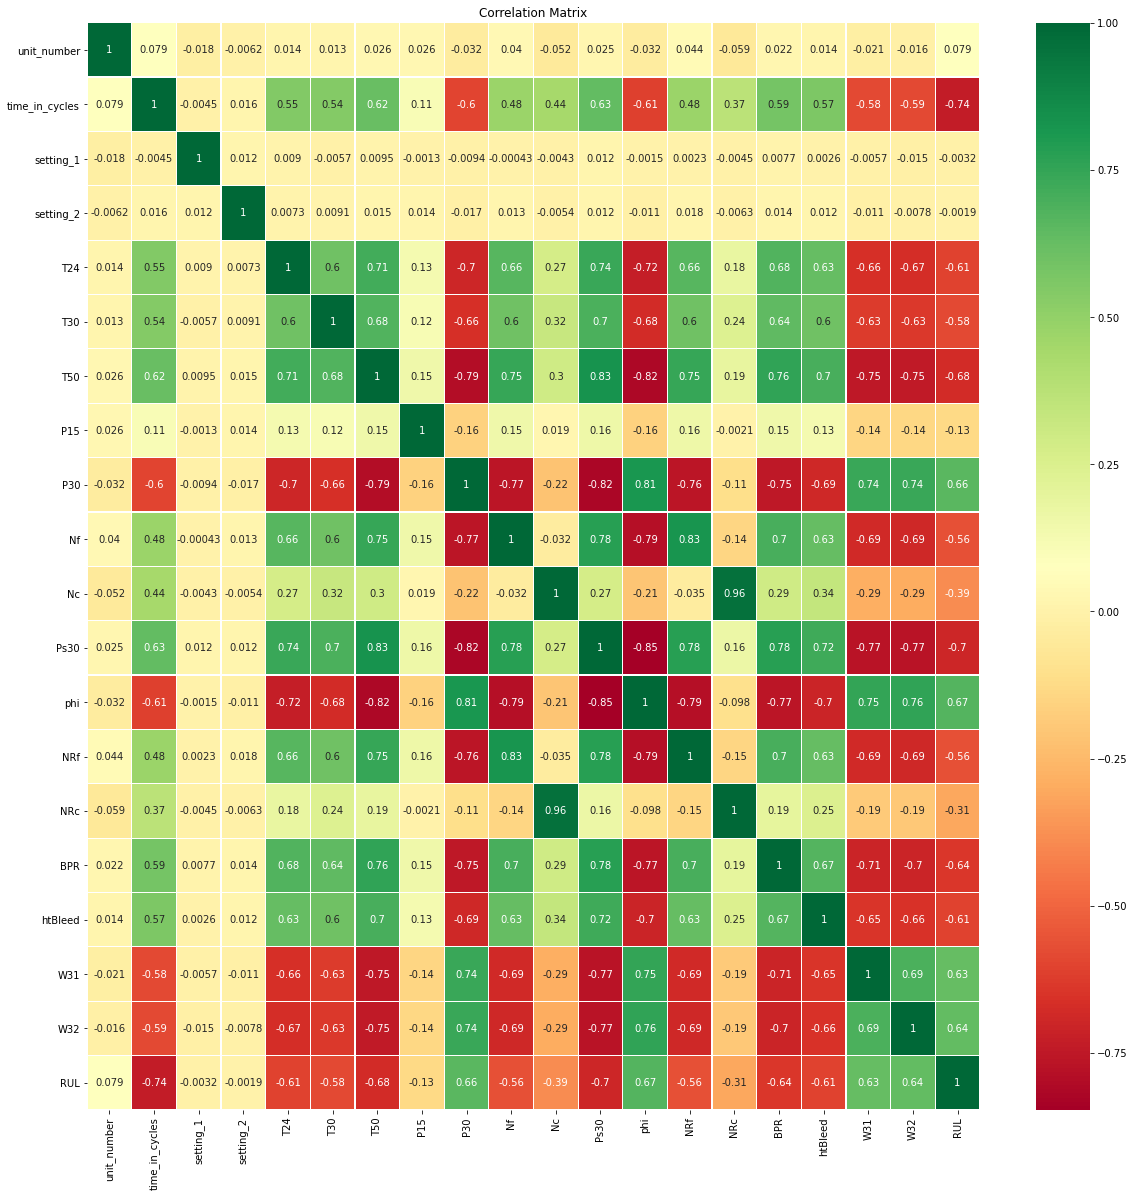

In [ ]:
# plot correlation matrix
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    import math
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score
    
   

In [ ]:
def score_func(y_true,y_pred):
   
    print(f' mean absolute error {round(mean_absolute_error(y_true,y_pred),5)}')
    print(f' mean squared error {round(mean_squared_error(y_true,y_pred),5)}')
    print(f' root mean squared error {round(mean_squared_error(y_true,y_pred),5) ** 0.5}')
    print(f' R2 score {round(r2_score(y_true,y_pred),5)}')
    return
    



We remove the properties that weakly correlate with the RUL target: setting_1, setting_2, P15, unit_number, as well as one of the features that are highly correlated with each other (Nc and NRc have a correlation coefficient of 0.96, remove NRc)

In [ ]:
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

train_df.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [ ]:
#function for creating and training models using the "Random forest", SVR and "XGBoost" algorithms

def train_models(data, model):
    X = data.iloc[:,:14].to_numpy() 
    Y = data.iloc[:,14:].to_numpy()
    Y = np.ravel(Y)

    if model == 'RF':
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X,Y)
        return model
    elif model == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=3,silent=True)
        model.fit(X,Y)
        return model

    elif model == 'SVR':
        model = SVR()
        model.fit(X,Y)
        return model
    return

In [ ]:
#function for joint display of real and predicted values

def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('Comparison of real and predicted values ')
    plt.show()
    return

In [ ]:
def plot_pred(test_labels, preds, model_name):
  # plot actual vs predicted Remaining Useful Life for the  model
  fig, ax = plt.subplots()
  ax.scatter(test_labels, preds, edgecolors=(0, 0, 0))
  ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'g', lw=4)
  ax.set_xlabel('Actual RUL')
  ax.set_ylabel('Predicted RUL')
  ax.set_title(model_name)
  plt.show()


Prepare test data for classification only the features used in the training are needed and a line with the maximum value for this engine time_in_cycles (last)

In [ ]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [ ]:
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)
X_001_test = test.to_numpy()
X_001_test.shape

(100, 14)

# **Building Models**

Let's train the model on training data with the deleted properties 'unit_number', 'setting_1', 'setting_2', 'P15', 'NRc'




**XGB**

In [ ]:
grid_s_optimazer('XGB', X, y)

[12:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Score: -29.28475203586711
Best Hyperparameters: {'booster': 'gbtree', 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
No algorithm found check your algorithm name


 mean absolute error 14.74
 mean squared error 370.16
 root mean squared error 19.239542614105982
 R2 score 0.79


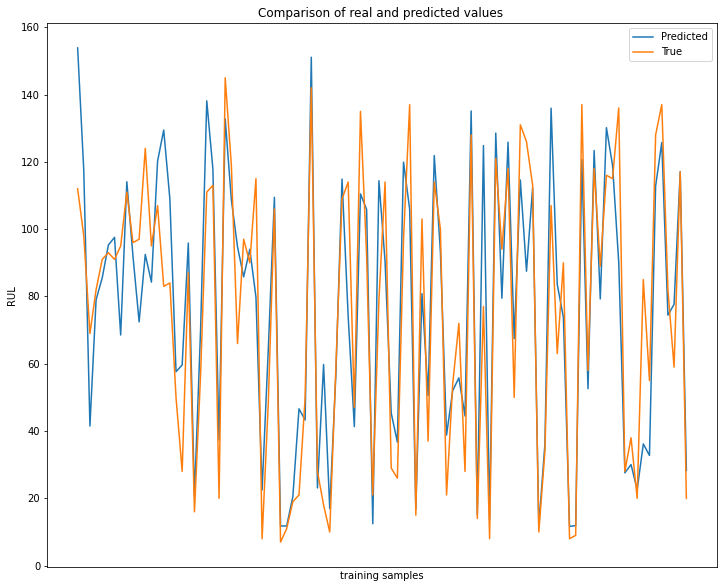

In [ ]:
model =train_models(train_df, 'XGB')
preds = model.predict(X_001_test)

score_func(y_true, preds)
plot_result(y_true,preds)

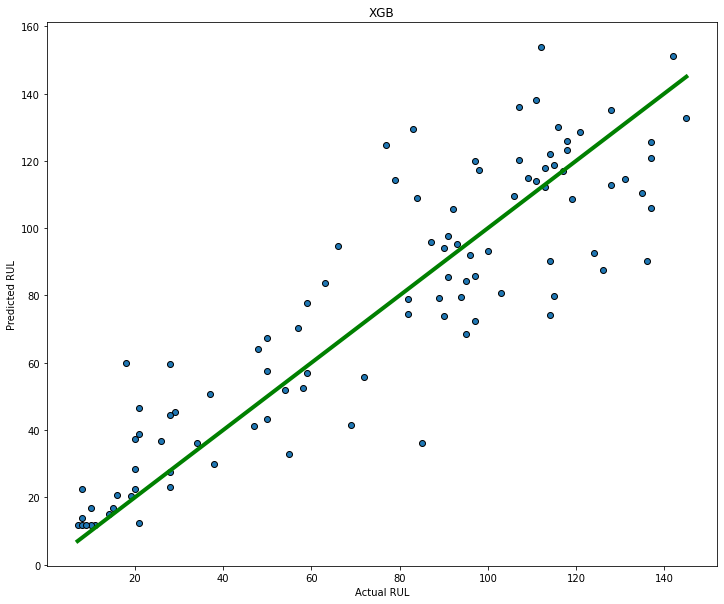

In [ ]:
plot_pred(y_true, preds, 'XGB')

**RF**

In [ ]:
grid_s_optimazer('RF', X, y)

 mean absolute error 19.25
 mean squared error 597.91
 root mean squared error 24.45219826518671
 R2 score 0.65


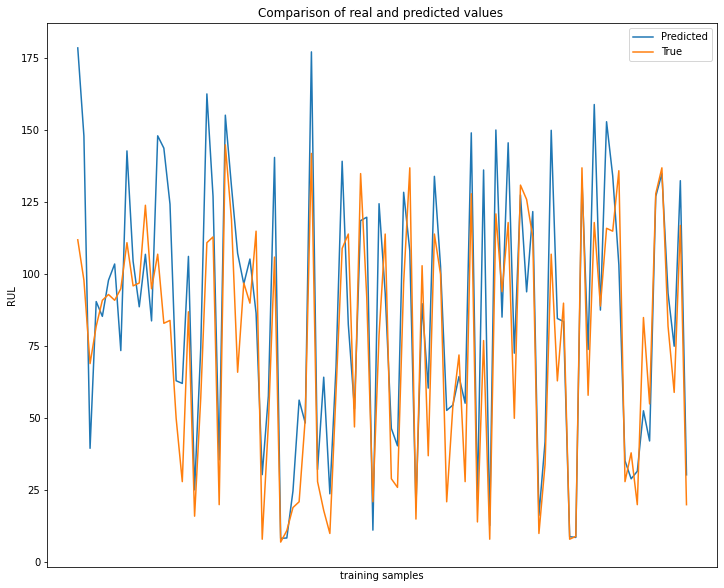

In [ ]:
model =train_models(train_df, 'RF')
preds = model.predict(X_001_test)

score_func(y_true, preds)
plot_result(y_true,preds)



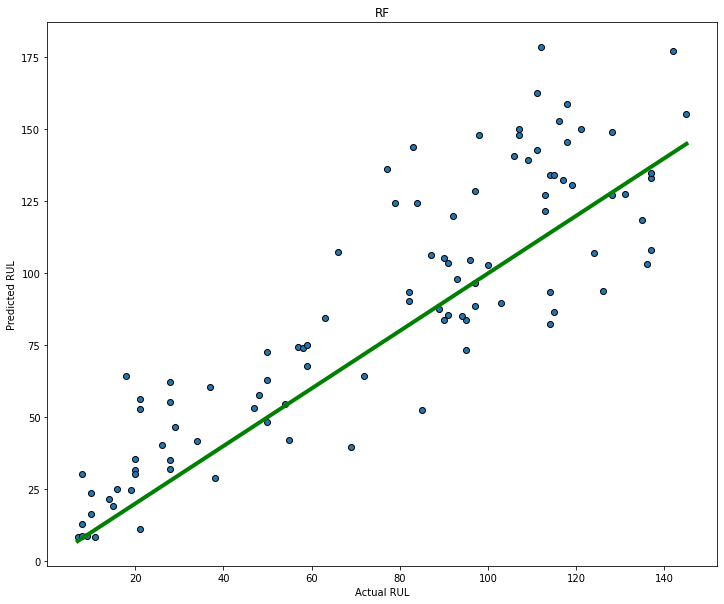

In [ ]:
plot_pred(y_true, preds, 'RF')

**SVR**

 mean absolute error 37.97
 mean squared error 2352.66
 root mean squared error 48.5042266199555
 R2 score -0.36


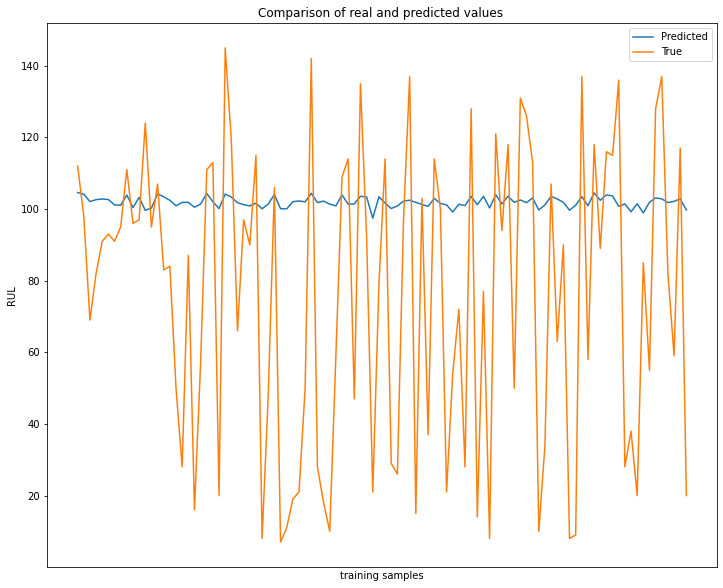

In [ ]:
model =train_models(train_df, 'SVR')
preds = model.predict(X_001_test)

score_func(y_true, preds)
plot_result(y_true, preds)

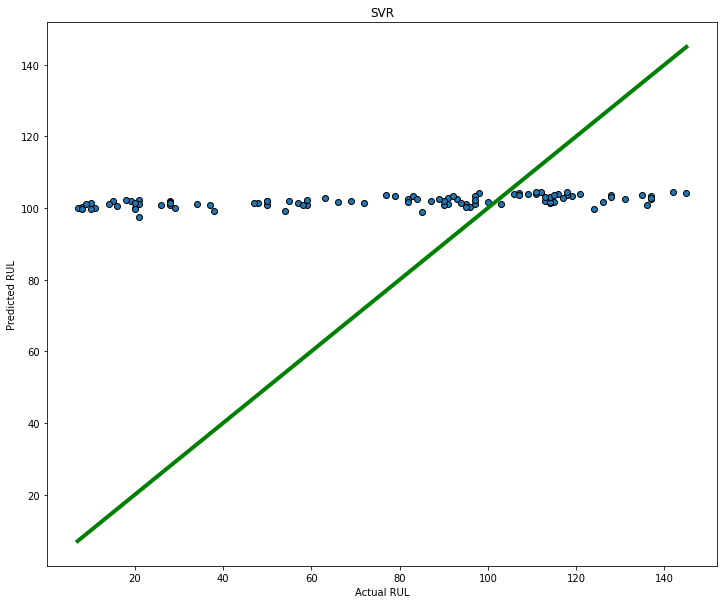

In [ ]:
plot_pred(y_true, preds, 'SVR')

# **XGB_GA**

0
1
2
3
4
5
6
7
This is number 0 generation
Best F score in this iteration = 0.6002
[2]
This is number 1 generation
Best F score in this iteration = 0.6267
[2]
This is number 2 generation
Best F score in this iteration = 0.6267
[1]
This is number 3 generation
Best F score in this iteration = 0.6267
[2]
Best fitness is = 0.6267
Best parameters are:
learning_rate 0.73
n_estimators 111.0
max_depth 1
min_child_weight 0.39
gamma 9.57
subsample 0.84
colsample_bytree 0.18


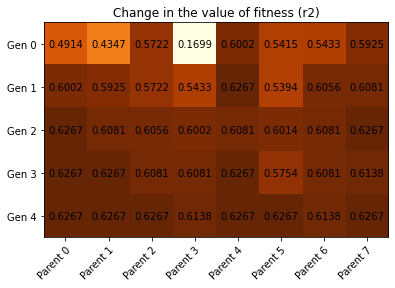

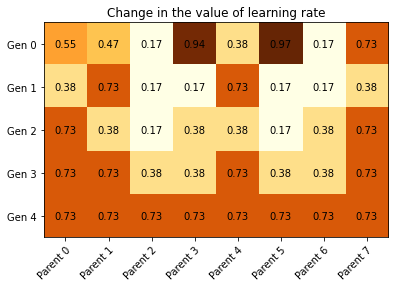

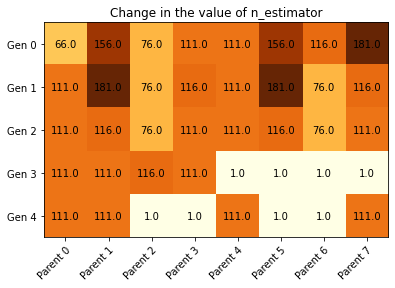

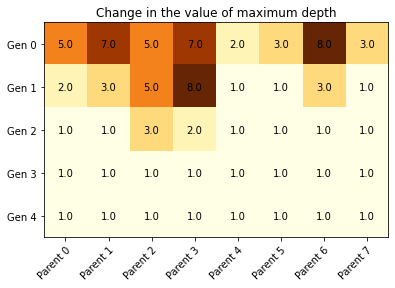

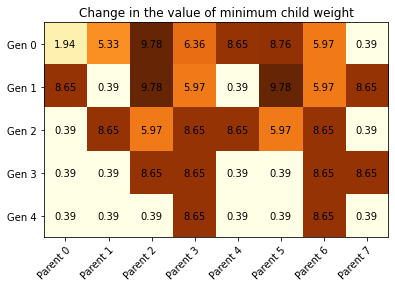

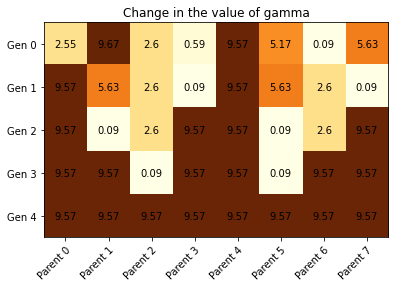

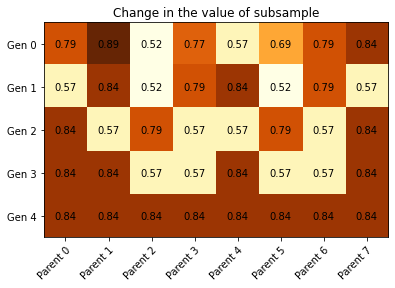

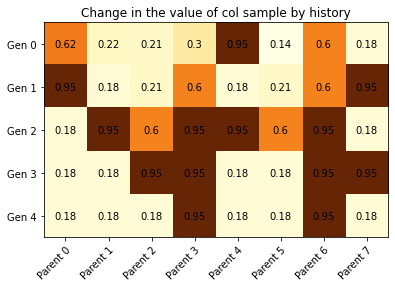

In [ ]:
class geneticXGboost:

  from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error
  import numpy as np
  import random
  import xgboost as xgb
  import matplotlib.pyplot as plt
  import random


  random.seed(723)
  np.random.seed(723)

  def initilialize_poplulation(numberOfParents):
      learningRate = np.empty([numberOfParents, 1])
      nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
      maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
      minChildWeight = np.empty([numberOfParents, 1])
      gammaValue = np.empty([numberOfParents, 1])
      subSample = np.empty([numberOfParents, 1])
      colSampleByTree =  np.empty([numberOfParents, 1])

      for i in range(numberOfParents):
          print(i)
          learningRate[i] = round(random.uniform(0.01, 1.0), 2)
          nEstimators[i] = random.randrange(1, 200, step = 5)
          maxDepth[i] = int(random.randrange(1, 10, step= 1))
          minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
          gammaValue[i] = round(random.uniform(0, 10.0), 2)
          subSample[i] = round(random.uniform(0.1, 1.0), 2)
          colSampleByTree[i] = round(random.uniform(0.1, 1.0), 2)
    
      population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
      return population


  #create fitness function that will predict F1_score    

  def fitness_f1score(y_true, y_pred):
      fitness = round((r2_score(y_true, y_pred)), 4)
      return fitness

  #train the data annd find fitness score
  def train_population(population, dMatrixTrain, dMatrixtest, y_test):
      fScore = []
      for i in range(population.shape[0]):
          param = { 'objective':'reg:squarederror',
                   'silent' : True,
                'learning_rate': population[i][0],
                'n_estimators': population[i][1], 
                'max_depth': int(population[i][2]), 
                'min_child_weight': population[i][3],
                'gamma': population[i][4], 
                'subsample': population[i][5],
                'colsample_bytree': population[i][6],
                # 'seed': 24
                }
          num_round = 100
          xgbT = xgb.train(param, dMatrixTrain, num_round)
          preds = xgbT.predict(dMatrixtest)
          # preds = preds>0.9
          fScore.append(fitness_f1score(y_test, preds))
      return fScore



  #select parents for mating
  def new_parents_selection(population, fitness, numParents):
      selectedParents = np.empty((numParents, population.shape[1])) #create an array to store fittest parents
    
      #find the top best performing parents
      for parentId in range(numParents):
          bestFitnessId = np.where(fitness == np.max(fitness))
          bestFitnessId  = bestFitnessId[0][0]
          selectedParents[parentId, :] = population[bestFitnessId, :]
          fitness[bestFitnessId] = -1 #set this value to negative, in case of F1-score, so this parent is not selected again
      return selectedParents
        
  '''
  Mate these parents to create chilren having parameters from these parents (we are using uniform crossover method)
  '''
  def crossover_uniform(parents, childrenSize):
    
      crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) #get all the index
      crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
      crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
      children = np.empty(childrenSize)
    

      '''
      Create child by choosing parameters from two paraents selected using new_parent_selection function. The parameter values
      will be picked from the indexes, which were randomly selected above. 
      '''
      for i in range(childrenSize[0]):
          #find parent 1 index 
          parent1_index = i%parents.shape[0]
          #find parent 2 index
          parent2_index = (i+1)%parents.shape[0]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
      return children
    
  '''
  Introduce some mutation in the children. In case of XGboost we will introdcue mutation randomly on each parameter one at a time,
  based on which parameter is selected at random. Initially, we will define the maximum/minimum value that is allowed for the parameter, to prevent the
  out the range error during runtime. Subsequently, we will generate mutation value and add it to the parameter, and return the mutated offspring!!!
  '''

  def mutation(crossover, numberOfParameters):
      #Define minimum and maximum values allowed for each parameter

      minMaxValue = np.zeros((numberOfParameters, 2))
    
      minMaxValue[0:] = [0.01, 1.0] #min/max learning rate
      minMaxValue[1, :] = [1, 200] #min/max n_estimator
      minMaxValue[2, :] = [1, 100] #min/max depth
      minMaxValue[3, :] = [0, 100.0] #min/max child_weight
      minMaxValue[4, :] = [0, 100.0] #min/max gamma
      minMaxValue[5, :] = [0.1, 1.0] #min/maxsubsample
      minMaxValue[6, :] = [0.1, 1.0] #min/maxcolsample_bytree
 
      # Mutation changes a single gene in each offspring randomly.
      mutationValue = 0
      parameterSelect = np.random.randint(0, 7, 1)
      print(parameterSelect)
      if parameterSelect == 0: #learning_rate
          mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
      if parameterSelect == 1: #n_estimators
          mutationValue = np.random.randint(-200, 200, 1)
      if parameterSelect == 2: #max_depth
          mutationValue = np.random.randint(-5, 5, 1)
      if parameterSelect == 3: #min_child_weight
          mutationValue = round(np.random.uniform(5, 5), 2)
      if parameterSelect == 4: #gamma
          mutationValue = round(np.random.uniform(-2, 2), 2)
      if parameterSelect == 5: #subsample
          mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
      if parameterSelect == 6: #colsample
          mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
      #indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
      for idx in range(crossover.shape[0]):
          crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
          if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
          if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
      return crossover


  '''
  This function will allow us to genrate the heatmap for various parameters and fitness to visualize 
  how each parameter and fitness changes with each generation
  '''

  def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
      #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
      generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
      populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
      fig, ax = plt.subplots()
      im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    
      # show ticks
      ax.set_xticks(np.arange(len(populationList)))
      ax.set_yticks(np.arange(len(generationList)))
    
      # show labels
      ax.set_xticklabels(populationList)
      ax.set_yticklabels(generationList)
    
      # set ticks at 45 degrees and rotate around anchor
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
    
    
      # insert the value of the parameter in each cell
      for i in range(len(generationList)):
          for j in range(len(populationList)):
              text = ax.text(j, i, parameter[i, j],
                            ha="center", va="center", color="k")
    
      ax.set_title("Change in the value of " + parameterName)
      fig.tight_layout()
      plt.show()



###################################################################################################################################################################################


# '''
# We will use genetic algorithum to optimize hyperparameters for XGboost using the above class created . 
# '''

# Importing the libraries
import numpy as np
import pandas as pd
import xgboost as xgb


np.random.seed(723)


#XGboost Classifier

#model xgboost
#use xgboost API now
X = train_df.iloc[:,:14].to_numpy() 
Y = train_df.iloc[:,14:].to_numpy()
Y = np.ravel(Y)

X_train = X
y_train = Y
X_test = X_001_test
y_test = y_true

xgDMatrix = xgb.DMatrix(X_train, y_train) #create Dmatrix
xgbDMatrixTest = xgb.DMatrix(X_test, y_test)


# '''
# Let's find optimized parameters using genetic algorithms
# '''

numberOfParents = 8 #number of parents to start
numberOfParentsMating = 4 #number of parents that will mate
numberOfParameters = 7 #number of parameters that will be optimized
numberOfGenerations = 4 #number of genration that will be created

#define the population size

populationSize = (numberOfParents, numberOfParameters)

#initialize the population with randomly generated parameters
population = geneticXGboost.initilialize_poplulation(numberOfParents)

#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])

#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters to history
populationHistory[0:numberOfParents, :] = population

for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))
    
    #train the dataset and obtain fitness
    fitnessValue = geneticXGboost.train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=y_test)
    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration
    print('Best F score in this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

    #survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = geneticXGboost.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    
    #mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = geneticXGboost.crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
    
    #add mutation to create genetic diversity
    children_mutated = geneticXGboost.mutation(children, numberOfParameters)
    
    # '''
    # We will create new population, which will contain parents that where selected previously based on the
    # fitness score and rest of them  will be children
    # '''
    population[0:parents.shape[0], :] = parents #fittest parents
    population[parents.shape[0]:, :] = children_mutated #children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #srore parent information
    

#Best solution from the final iteration

fitness = geneticXGboost.train_population(population=population, dMatrixTrain=xgDMatrix, dMatrixtest=xgbDMatrixTest, y_test=y_test)
fitnessHistory[generation+1, :] = fitness

#index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

#Best fitness
print("Best fitness is =", fitness[bestFitnessIndex])

#Best parameters
print("Best parameters are:")
print('learning_rate', population[bestFitnessIndex][0])
print('n_estimators', population[bestFitnessIndex][1])
print('max_depth', int(population[bestFitnessIndex][2])) 
print('min_child_weight', population[bestFitnessIndex][3])
print('gamma', population[bestFitnessIndex][4])
print('subsample', population[bestFitnessIndex][5])
print('colsample_bytree', population[bestFitnessIndex][6])


#visualize the change in fitness of the various generations and parents


geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (r2)")

#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)

learnigRateHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])
nEstimatorHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])
maxdepthHistory = populationHistory[:, 2].reshape([numberOfGenerations+1, numberOfParents])
minChildWeightHistory = populationHistory[:, 3].reshape([numberOfGenerations+1, numberOfParents])
gammaHistory = populationHistory[:, 4].reshape([numberOfGenerations+1, numberOfParents])
subsampleHistory = populationHistory[:, 5].reshape([numberOfGenerations+1, numberOfParents])
colsampleByTreeHistory = populationHistory[:, 6].reshape([numberOfGenerations+1, numberOfParents])

#generate heatmap for each parameter

geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, learnigRateHistory, "learning rate")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, nEstimatorHistory, "n_estimator")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, maxdepthHistory, "maximum depth")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, minChildWeightHistory, "minimum child weight")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, gammaHistory, "gamma")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, subsampleHistory, "subsample")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, colsampleByTreeHistory, "col sample by history")


In [ ]:
from xgboost import XGBRegressor as xgb

model = xgb(
learning_rate =0.73,
n_estimators =111,
max_depth =1,
min_child_weight =0.39,
gamma =9.57,
subsample= 0.84,
colsample_bytree= 0.18,
silent = True

)

model.fit(X_train, y_train)

preds = model.predict(X_test)


print("Model Root Mean Squared Error: ", sqrt(mean_squared_error(y_test, preds)))
print("Model Mean Absolute Error: ", mean_absolute_error(y_test, preds))
print("Model r-squared: ", r2_score(y_test, preds))

[20:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model Root Mean Squared Error:  25.607523129654886
Model Mean Absolute Error:  18.313415241241454
Model r-squared:  0.6202693933370476


# **RF_GA**

0
1
2
3
4
5
6
7
This is number 0 generation
Best F score in this iteration = 0.5838
[4]
This is number 1 generation
Best F score in this iteration = 0.5768
[3]
This is number 2 generation
Best F score in this iteration = 0.5832
[1]
This is number 3 generation
Best F score in this iteration = 0.5822
[3]
Best fitness is = 0.5828
Best parameters are:
n_estimators 85
max_depth 91
max_lead_nodes 8
min_samples_split 85
min_samples_leaf 91
min_impurity_decrease 8


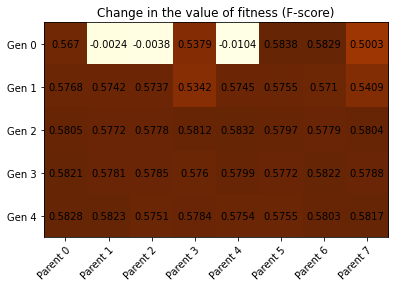

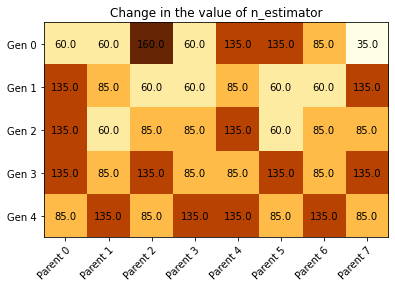

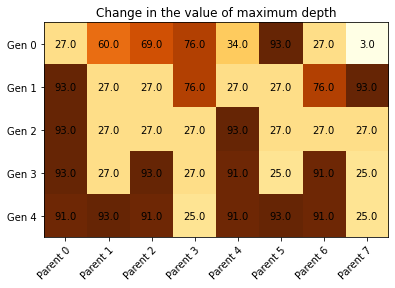

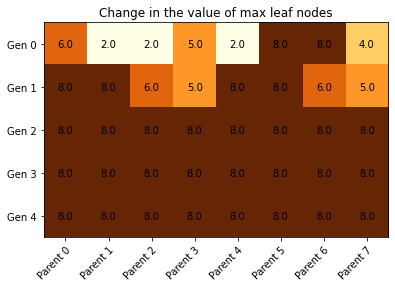

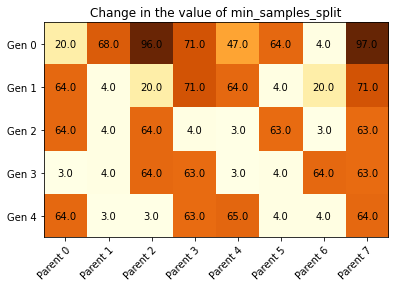

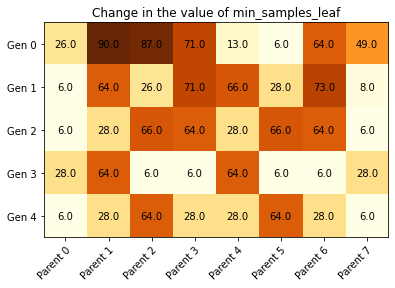

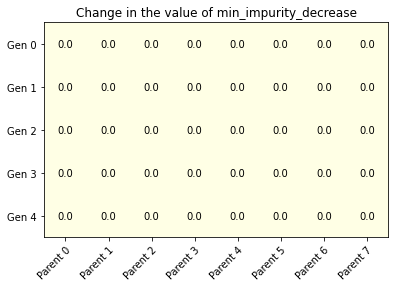

In [ ]:
class geneticXGboost:

  from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error
  import numpy as np
  import random
  import xgboost as xgb
  from sklearn.ensemble import RandomForestRegressor
  import matplotlib.pyplot as plt
  import random


  random.seed(723)
  np.random.seed(723)


  def initilialize_poplulation(numberOfParents):
      import random
      # learningRate = np.empty([numberOfParents, 1])

      nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
      maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
      maxleafnode = np.empty([numberOfParents, 1], dtype = np.uint8)

      min_samples_split = np.empty([numberOfParents, 1], dtype = np.uint8)
      min_samples_leaf = np.empty([numberOfParents, 1], dtype = np.uint8)
      min_impurity_decrease = np.empty([numberOfParents, 1], dtype = np.uint8)
      # max_features = np.empty([numberOfParents, 1], dtype = np.uint8)

      # minChildWeight = np.empty([numberOfParents, 1])
      # gammaValue = np.empty([numberOfParents, 1])
      # subSample = np.empty([numberOfParents, 1])
      # colSampleByTree =  np.empty([numberOfParents, 1])

      # RandomForestRegressor()
      n_features = X_train.shape[1]
      # print(n_features)
      for i in range(numberOfParents):
          print(i)
          # learningRate[i] = round(random.uniform(0.01, 1), 2)

          nEstimators[i] = random.randrange(10, 200, step = 25)
          maxDepth[i] = int(random.randrange(1, 100, step= 1))
          maxleafnode[i] = int(random.randrange(2, 10, step= 1))

          min_samples_split[i] = int(random.uniform(2, 100))
          min_samples_leaf[i] = int(random.uniform(1, 100))
          min_impurity_decrease[i] = int(random.uniform(0, 1 ))
          # max_features[i] = random.uniform(1, n_features)

          # min_samples_split[i] = random.uniform(2, 1000)
          # min_samples_leaf[i] = round(random.uniform(0.01, 10.0), 2)
          # min_weight_fraction_leaf[i] = round(random.uniform(0.01, 1.0), 2)
          # max_features[i] = round(random.uniform(0.01, 1.0), 2)
    
      # population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
      population = np.concatenate((nEstimators, maxDepth, maxleafnode,min_samples_split, min_samples_leaf, min_impurity_decrease), axis= 1)
      return population


  #create fitness function that will predict F1_score    

  def fitness_f1score(y_true, y_pred):
      fitness = round((r2_score(y_true, y_pred)), 4)
      return fitness

  #train the data annd find fitness score
  def train_population(population, x_train, y_train, x_test, y_test):
      fScore = []
      for i in range(population.shape[0]):
          param = {
              #  'objective':'reg:squarederror',
              #   'learning_rate': population[i][0],
                
                # 'random_state': 1,
                # 'n_jobs' : -1,
                # 'max_features' : 7,

                'n_estimators': population[i][0], 
                'max_depth': int(population[i][1]), 
                'max_leaf_nodes': population[i][2],

                'min_samples_split': population[i][3], 
                'min_samples_leaf': population[i][4],
                'min_impurity_decrease': population[i][5]
                
                # 'seed': 24
                }
          num_round = 100
          model = RandomForestRegressor(**param, 
                                        # random_state= 1,
                                        # n_jobs =-1,
                                        # max_features = 7
                                        
                                        )
          model =  model.fit(x_train, y_train)
          preds = model.predict(X_test)
          # preds = preds>0.5
          fScore.append(fitness_f1score(y_test, preds))
      return fScore



  #select parents for mating
  def new_parents_selection(population, fitness, numParents):
      selectedParents = np.empty((numParents, population.shape[1])) #create an array to store fittest parents
    
      #find the top best performing parents
      for parentId in range(numParents):
          bestFitnessId = np.where(fitness == np.max(fitness))
          bestFitnessId  = bestFitnessId[0][0]
          selectedParents[parentId, :] = population[bestFitnessId, :]
          fitness[bestFitnessId] = -1 #set this value to negative, in case of F1-score, so this parent is not selected again
      return selectedParents
        
  '''
  Mate these parents to create chilren having parameters from these parents (we are using uniform crossover method)
  '''
  def crossover_uniform(parents, childrenSize):
    
      crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) #get all the index
      crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
      crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
      children = np.empty(childrenSize)
    

      '''
      Create child by choosing parameters from two paraents selected using new_parent_selection function. The parameter values
      will be picked from the indexes, which were randomly selected above. 
      '''
      for i in range(childrenSize[0]):
          #find parent 1 index 
          parent1_index = i%parents.shape[0]
          #find parent 2 index
          parent2_index = (i+1)%parents.shape[0]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
      return children
    
  '''
  Introduce some mutation in the children. In case of XGboost we will introdcue mutation randomly on each parameter one at a time,
  based on which parameter is selected at random. Initially, we will define the maximum/minimum value that is allowed for the parameter, to prevent the
  out the range error during runtime. Subsequently, we will generate mutation value and add it to the parameter, and return the mutated offspring!!!
  '''

  def mutation(crossover, numberOfParameters):
      #Define minimum and maximum values allowed for each parameter

      minMaxValue = np.zeros((numberOfParameters, 2))
    
      # minMaxValue[0:] = [0.01, 1.0] #min/max learning rate
      minMaxValue[0, :] = [10, 200] #min/max n_estimator
      minMaxValue[1, :] = [1, 100] #min/max depth
      minMaxValue[2, :] = [1, 100] #min/max child_weight

      minMaxValue[3, :] = [2, 100] #min/max min_samples_split
      minMaxValue[4, :] = [1, 100] #min/max min_samples_leaf
      minMaxValue[5, :] = [1, 100] #min/max min_impurity_decrease

      # minMaxValue[6, :] = [0, 1] #min/max max_features
 
      # Mutation changes a single gene in each offspring randomly.
      mutationValue = 0
      parameterSelect = np.random.randint(0, 6, 1)
      print(parameterSelect)
      # if parameterSelect == 0: #learning_rate
      #     mutationValue = round(np.random.uniform(-0.5, 0.5), 2)

      if parameterSelect == 0: #n_estimators
          mutationValue = np.random.randint(-200, 200, 1)
      if parameterSelect == 1: #max_depth
          mutationValue = np.random.randint(-5, 5, 1)
      if parameterSelect == 2: #min_child_weight
          mutationValue = np.random.randint(-5, 5, 2)

      if parameterSelect == 3: #min_samples_split
          mutationValue = np.random.randint(-5, 5, 1)
      if parameterSelect == 4: #min_samples_leaf
          mutationValue = np.random.randint(-5, 5, 1)
      if parameterSelect == 5: #min_impurity_decrease
          mutationValue = np.random.randint(-5, 5, 1)

      # if parameterSelect == 5: #max_features
      #     mutationValue = np.random.randint(-5, 5, 1)
  
      #indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
      for idx in range(crossover.shape[0]):
          crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
          if (crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
          if (crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
      return crossover

  '''
  This function will allow us to genrate the heatmap for various parameters and fitness to visualize 
  how each parameter and fitness changes with each generation
  '''

  def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
      #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
      generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
      populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
      fig, ax = plt.subplots()
      im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    
      # show ticks
      ax.set_xticks(np.arange(len(populationList)))
      ax.set_yticks(np.arange(len(generationList)))
    
      # show labels
      ax.set_xticklabels(populationList)
      ax.set_yticklabels(generationList)
    
      # set ticks at 45 degrees and rotate around anchor
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
    
    
      # insert the value of the parameter in each cell
      for i in range(len(generationList)):
          for j in range(len(populationList)):
              text = ax.text(j, i, parameter[i, j],
                            ha="center", va="center", color="k")
    
      ax.set_title("Change in the value of " + parameterName)
      fig.tight_layout()
      plt.show()



###################################################################################################################################################################################


# '''
# We will use genetic algorithum to optimize hyperparameters for XGboost using the above class created . 
# '''

# Importing the libraries
import numpy as np
import pandas as pd
import xgboost as xgb


np.random.seed(723)


#XGboost Classifier

#model xgboost
#use xgboost API now
X = train_df.iloc[:,:14].to_numpy() 
Y = train_df.iloc[:,14:].to_numpy()
Y = np.ravel(Y)

X_train = X
y_train = Y
X_test = X_001_test
y_test = y_true

# xgDMatrix = xgb.DMatrix(X_train, y_train) #create Dmatrix
# xgbDMatrixTest = xgb.DMatrix(X_test, y_test)


# '''
# Let's find optimized parameters using genetic algorithms
# '''

numberOfParents = 8 #number of parents to start
numberOfParentsMating = 4 #number of parents that will mate
numberOfParameters = 6 #number of parameters that will be optimized
numberOfGenerations = 4 #number of genration that will be created

#define the population size

populationSize = (numberOfParents, numberOfParameters)

#initialize the population with randomly generated parameters
population = geneticXGboost.initilialize_poplulation(numberOfParents)

#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])

#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters to history
populationHistory[0:numberOfParents, :] = population

for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))
    
    #train the dataset and obtain fitness
    fitnessValue = geneticXGboost.train_population(population, X_train, y_train, X_test, y_test)
    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration
    print('Best F score in this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

    #survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = geneticXGboost.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    
    #mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = geneticXGboost.crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
    
    #add mutation to create genetic diversity
    children_mutated = geneticXGboost.mutation(children, numberOfParameters)
    
    # '''
    # We will create new population, which will contain parents that where selected previously based on the
    # fitness score and rest of them  will be children
    # '''
    population[0:parents.shape[0], :] = parents #fittest parents
    population[parents.shape[0]:, :] = children_mutated #children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #srore parent information
    

#Best solution from the final iteration

fitness = geneticXGboost.train_population(population, X_train, y_train, X_test, y_test)
fitnessHistory[generation+1, :] = fitness

#index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

#Best fitness
print("Best fitness is =", fitness[bestFitnessIndex])

#Best parameters
print("Best parameters are:")
# print('learning_rate', population[bestFitnessIndex][0])


print('n_estimators', population[bestFitnessIndex][0])
print('max_depth', int(population[bestFitnessIndex][1])) 
print('max_lead_nodes', population[bestFitnessIndex][2])
print('min_samples_split', population[bestFitnessIndex][0])
print('min_samples_leaf', int(population[bestFitnessIndex][1])) 
print('min_impurity_decrease', population[bestFitnessIndex][2])

# print('gamma', population[bestFitnessIndex][4])
# print('subsample', population[bestFitnessIndex][5])
# print('colsample_bytree', population[bestFitnessIndex][6])


#visualize the change in fitness of the various generations and parents


geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (F-score)")

#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)

# learnigRateHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])

nEstimatorHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])
maxdepthHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])
maxleafnodeHistory = populationHistory[:, 2].reshape([numberOfGenerations+1, numberOfParents])
min_samples_splitHistory = populationHistory[:, 3].reshape([numberOfGenerations+1, numberOfParents])
min_samples_leafHistory = populationHistory[:, 4].reshape([numberOfGenerations+1, numberOfParents])
min_impurity_decreaseHistory = populationHistory[:, 5].reshape([numberOfGenerations+1, numberOfParents])


# gammaHistory = populationHistory[:, 4].reshape([numberOfGenerations+1, numberOfParents])
# subsampleHistory = populationHistory[:, 5].reshape([numberOfGenerations+1, numberOfParents])
# colsampleByTreeHistory = populationHistory[:, 6].reshape([numberOfGenerations+1, numberOfParents])

#generate heatmap for each parameter

# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, learnigRateHistory, "learning rate")

geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, nEstimatorHistory, "n_estimator")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, maxdepthHistory, "maximum depth")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, maxleafnodeHistory, "max leaf nodes")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, min_samples_splitHistory, "min_samples_split")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, min_samples_leafHistory, "min_samples_leaf")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, min_impurity_decreaseHistory, "min_impurity_decrease")


# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, gammaHistory, "gamma")
# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, subsampleHistory, "subsample")
# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, colsampleByTreeHistory, "col sample by history")


In [ ]:
model = RandomForestRegressor(
n_estimators =85,
max_depth =91,
max_leaf_nodes =8,
min_samples_split =85,
min_samples_leaf =91,
min_impurity_decrease= 8,
random_state = 126
)

model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Model Root Mean Squared Error: ", sqrt(mean_squared_error(y_test, preds)))
print("Model Mean Absolute Error: ", mean_absolute_error(y_test, preds))
print("Model r-squared: ", r2_score(y_test, preds))

Model Root Mean Squared Error:  26.739604917993596
Model Mean Absolute Error:  20.619091031956472
Model r-squared:  0.5859522507255976


# **SVC_GA**

0
1
2
3
4
5
6
7
This is number 0 generation
Best F score in this iteration = -0.0001
[0]
This is number 1 generation
Best F score in this iteration = -0.0001
[0]
This is number 2 generation
Best F score in this iteration = 0.1912
[2]
This is number 3 generation
Best F score in this iteration = 0.1912
[0]
Best fitness is = 0.1912
Best parameters are:
C 20.0
degree 1
epsilon 1.0


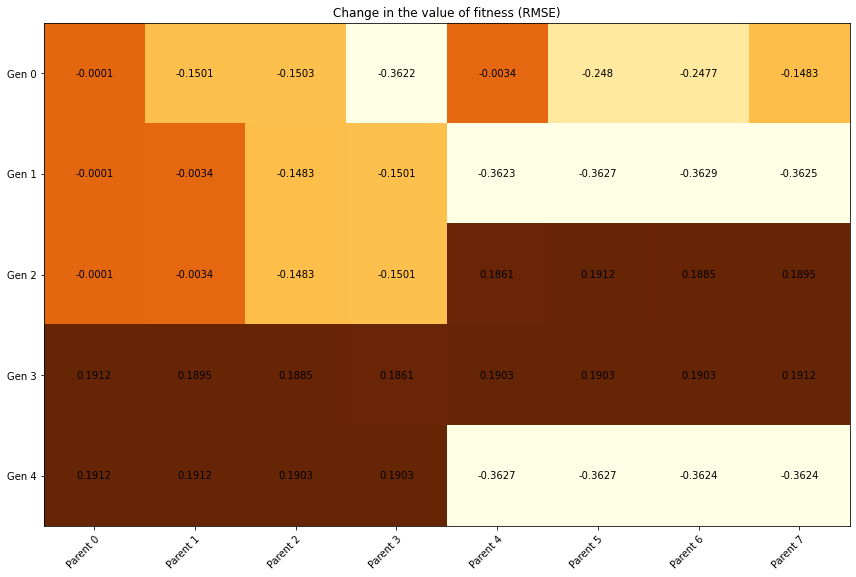

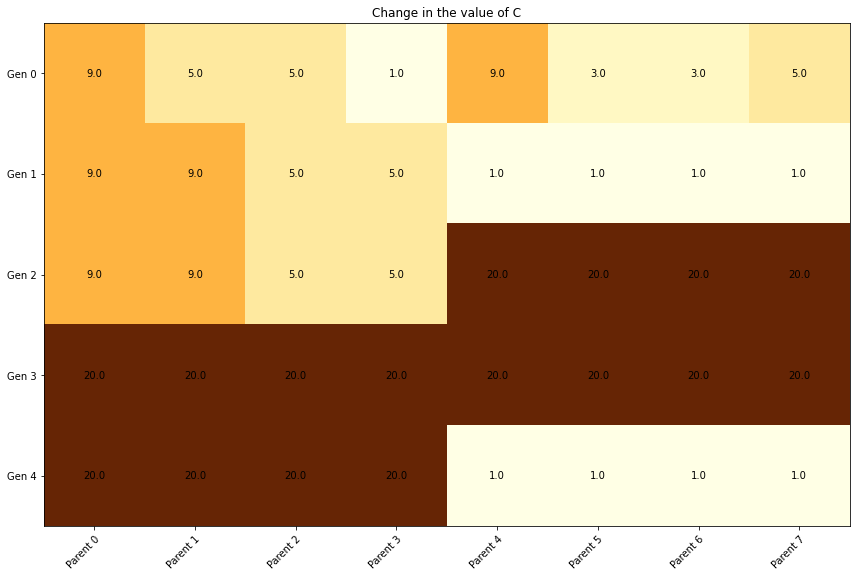

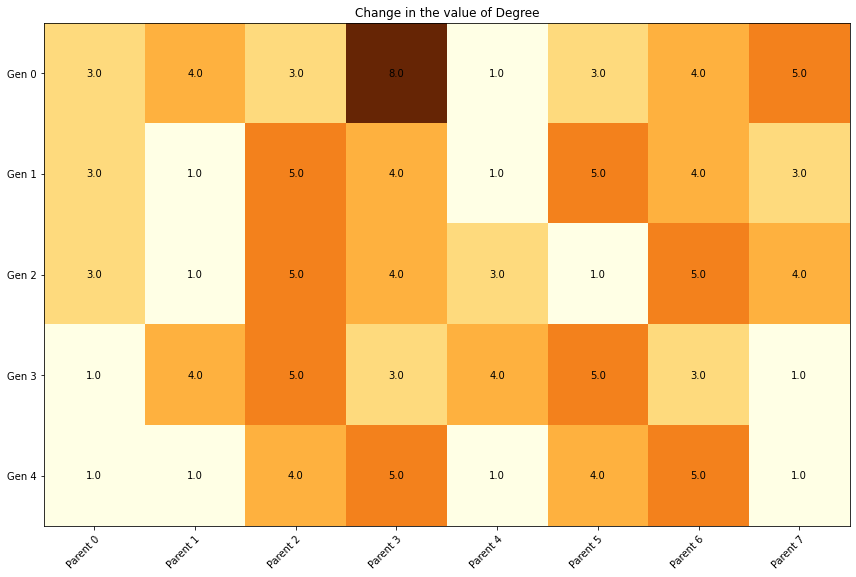

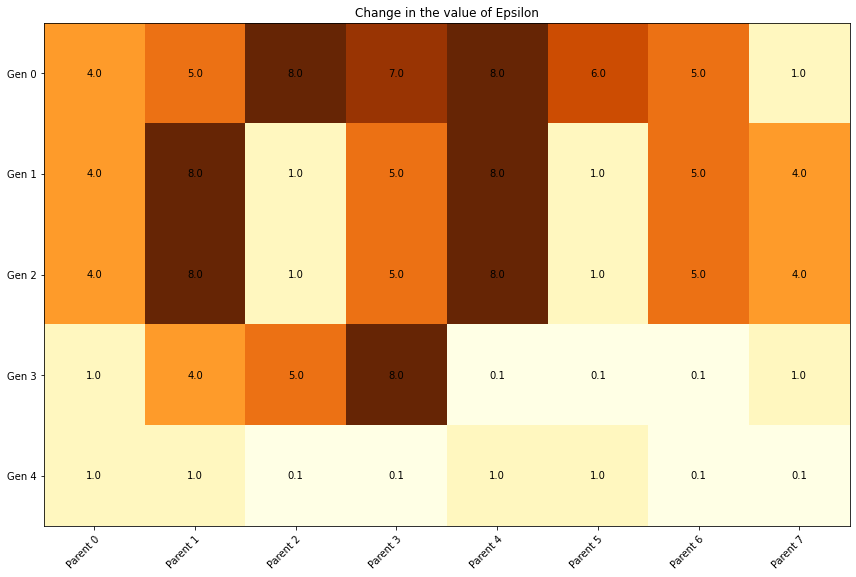

In [ ]:
class geneticXGboost:

  from sklearn.metrics import f1_score, r2_score, mean_squared_error, mean_absolute_error
  import numpy as np
  import random
  import xgboost as xgb
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.svm import SVR
  import matplotlib.pyplot as plt
  import random


  random.seed(723)
  np.random.seed(723)

  def initilialize_poplulation(numberOfParents):
      import random
      # learningRate = np.empty([numberOfParents, 1])

      C = np.empty([numberOfParents, 1], dtype = np.uint8)
      degree = np.empty([numberOfParents, 1], dtype = np.uint8)
      epsilon = np.empty([numberOfParents, 1])

      # minChildWeight = np.empty([numberOfParents, 1])
      # gammaValue = np.empty([numberOfParents, 1])
      # subSample = np.empty([numberOfParents, 1])
      # colSampleByTree =  np.empty([numberOfParents, 1])

      for i in range(numberOfParents):
          print(i)
          # learningRate[i] = round(random.uniform(0.01, 1), 2)

          C[i] = random.randrange(1, 10, step = 2)
          degree[i] = int(random.randrange(1, 10, step= 1))
          epsilon[i] = int(random.randrange(1, 10, step= 1))

          # minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
          # gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
          # subSample[i] = round(random.uniform(0.01, 1.0), 2)
          # colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)
    
      # population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
      population = np.concatenate((C, degree, epsilon), axis= 1)
      return population


  #create fitness function that will predict F1_score    

  def fitness_f1score(y_true, y_pred):
      fitness = round((r2_score(y_true, y_pred)), 4)
      return fitness

  #train the data annd find fitness score
  def train_population(population, x_train, y_train, x_test, y_test):
      fScore = []
      for i in range(population.shape[0]):
          param = {
              #  'objective':'reg:squarederror',
              #   'learning_rate': population[i][0],
                'C': population[i][0], 
                'degree': int(population[i][1]), 
                'epsilon': population[i][2],

                # 'gamma': population[i][4], 
                # 'subsample': population[i][5],
                # 'colsample_bytree': population[i][6],
                # 'seed': 24
                }
          num_round = 100
          model = SVR(**param)
          model =  model.fit(x_train, y_train)
          preds = model.predict(X_test)
          # preds = preds>0.5
          fScore.append(fitness_f1score(y_test, preds))
      return fScore



  #select parents for mating
  def new_parents_selection(population, fitness, numParents):
      selectedParents = np.empty((numParents, population.shape[1])) #create an array to store fittest parents
    
      #find the top best performing parents
      for parentId in range(numParents):
          bestFitnessId = np.where(fitness == np.max(fitness))
          bestFitnessId  = bestFitnessId[0][0]
          selectedParents[parentId, :] = population[bestFitnessId, :]
          fitness[bestFitnessId] = -1 #set this value to negative, in case of F1-score, so this parent is not selected again
      return selectedParents
        
  '''
  Mate these parents to create chilren having parameters from these parents (we are using uniform crossover method)
  '''
  def crossover_uniform(parents, childrenSize):
    
      crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) #get all the index
      crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
      crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
      children = np.empty(childrenSize)
    

      '''
      Create child by choosing parameters from two paraents selected using new_parent_selection function. The parameter values
      will be picked from the indexes, which were randomly selected above. 
      '''
      for i in range(childrenSize[0]):
          #find parent 1 index 
          parent1_index = i%parents.shape[0]
          #find parent 2 index
          parent2_index = (i+1)%parents.shape[0]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
          #insert parameters based on random selected indexes in parent 1
          children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
      return children
    
  '''
  Introduce some mutation in the children. In case of XGboost we will introdcue mutation randomly on each parameter one at a time,
  based on which parameter is selected at random. Initially, we will define the maximum/minimum value that is allowed for the parameter, to prevent the
  out the range error during runtime. Subsequently, we will generate mutation value and add it to the parameter, and return the mutated offspring!!!
  '''

  def mutation(crossover, numberOfParameters):
      #Define minimum and maximum values allowed for each parameter

      minMaxValue = np.zeros((numberOfParameters, 2))
    
      # minMaxValue[0:] = [0.01, 1.0] #min/max learning rate
      minMaxValue[0, :] = [1, 20] #min/max n_estimator
      minMaxValue[1, :] = [1, 10] #min/max depth
      minMaxValue[2, :] = [0.1, 1.0] #min/max child_weight

      # minMaxValue[4, :] = [0.01, 100.0] #min/max gamma
      # minMaxValue[5, :] = [0.01, 1.0] #min/maxsubsample
      # minMaxValue[6, :] = [0.01, 1.0] #min/maxcolsample_bytree
 
      # Mutation changes a single gene in each offspring randomly.
      mutationValue = 0
      parameterSelect = np.random.randint(0, 3, 1)
      print(parameterSelect)
      # if parameterSelect == 0: #learning_rate
      #     mutationValue = round(np.random.uniform(-0.5, 0.5), 2)

      if parameterSelect == 0: #n_estimators
          mutationValue = np.random.randint(-200, 200, 1)
      if parameterSelect == 1: #max_depth
          mutationValue = np.random.randint(-5, 5, 1)
      if parameterSelect == 2: #min_child_weight
          mutationValue = np.random.randint(-5, 5, 1)

      # if parameterSelect == 4: #gamma
      #     mutationValue = round(np.random.uniform(-2, 2), 2)
      # if parameterSelect == 5: #subsample
      #     mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
      # if parameterSelect == 6: #colsample
      #     mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
      #indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
      for idx in range(crossover.shape[0]):
          crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
          if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
          if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
              crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
      return crossover


  '''
  This function will allow us to genrate the heatmap for various parameters and fitness to visualize 
  how each parameter and fitness changes with each generation
  '''

  def plot_parameters(numberOfGenerations, numberOfParents, parameter, parameterName):
      #inspired from https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
      generationList = ["Gen {}".format(i) for i in range(numberOfGenerations+1)]
      populationList = ["Parent {}".format(i) for i in range(numberOfParents)]
    
      fig, ax = plt.subplots()
      im = ax.imshow(parameter, cmap=plt.get_cmap('YlOrBr'))
    
      # show ticks
      ax.set_xticks(np.arange(len(populationList)))
      ax.set_yticks(np.arange(len(generationList)))
    
      # show labels
      ax.set_xticklabels(populationList)
      ax.set_yticklabels(generationList)
    
      # set ticks at 45 degrees and rotate around anchor
      plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
              rotation_mode="anchor")
    
    
      # insert the value of the parameter in each cell
      for i in range(len(generationList)):
          for j in range(len(populationList)):
              text = ax.text(j, i, parameter[i, j],
                            ha="center", va="center", color="k")
    
      ax.set_title("Change in the value of " + parameterName)
      fig.tight_layout()
      plt.show()



###################################################################################################################################################################################


# '''
# We will use genetic algorithum to optimize hyperparameters for XGboost using the above class created . 
# '''

# Importing the libraries
import numpy as np
import pandas as pd
import xgboost as xgb


np.random.seed(723)


#XGboost Classifier

#model xgboost
#use xgboost API now
X = train_df.iloc[:,:14].to_numpy() 
Y = train_df.iloc[:,14:].to_numpy()
Y = np.ravel(Y)

X_train = X
y_train = Y
X_test = X_001_test
y_test = y_true

# xgDMatrix = xgb.DMatrix(X_train, y_train) #create Dmatrix
# xgbDMatrixTest = xgb.DMatrix(X_test, y_test)


# '''
# Let's find optimized parameters using genetic algorithms
# '''

numberOfParents = 8 #number of parents to start
numberOfParentsMating = 4 #number of parents that will mate
numberOfParameters = 3 #number of parameters that will be optimized
numberOfGenerations = 4 #number of genration that will be created

#define the population size

populationSize = (numberOfParents, numberOfParameters)

#initialize the population with randomly generated parameters
population = geneticXGboost.initilialize_poplulation(numberOfParents)

#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])

#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])

#insert the value of initial parameters to history
populationHistory[0:numberOfParents, :] = population

for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))
    
    #train the dataset and obtain fitness
    fitnessValue = geneticXGboost.train_population(population, X_train, y_train, X_test, y_test)
    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration
    print('Best F score in this iteration = {}'.format(np.max(fitnessHistory[generation, :])))

    #survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = geneticXGboost.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    
    #mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = geneticXGboost.crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
    
    #add mutation to create genetic diversity
    children_mutated = geneticXGboost.mutation(children, numberOfParameters)
    
    # '''
    # We will create new population, which will contain parents that where selected previously based on the
    # fitness score and rest of them  will be children
    # '''
    population[0:parents.shape[0], :] = parents #fittest parents
    population[parents.shape[0]:, :] = children_mutated #children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #srore parent information
    

#Best solution from the final iteration

fitness = geneticXGboost.train_population(population, X_train, y_train, X_test, y_test)
fitnessHistory[generation+1, :] = fitness

#index of the best solution
bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]

#Best fitness
print("Best fitness is =", fitness[bestFitnessIndex])

#Best parameters
print("Best parameters are:")
# print('learning_rate', population[bestFitnessIndex][0])

print('C', population[bestFitnessIndex][0])
print('degree', int(population[bestFitnessIndex][1])) 
print('epsilon', population[bestFitnessIndex][2])

# print('gamma', population[bestFitnessIndex][4])
# print('subsample', population[bestFitnessIndex][5])
# print('colsample_bytree', population[bestFitnessIndex][6])


#visualize the change in fitness of the various generations and parents


geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, fitnessHistory, "fitness (RMSE)")

#Look at individual parameters change with generation
#Create array for each parameter history (Genration x Parents)

# learnigRateHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])

nEstimatorHistory = populationHistory[:, 0].reshape([numberOfGenerations+1, numberOfParents])
maxdepthHistory = populationHistory[:, 1].reshape([numberOfGenerations+1, numberOfParents])
maxleafnodeHistory = populationHistory[:, 2].reshape([numberOfGenerations+1, numberOfParents])

# gammaHistory = populationHistory[:, 4].reshape([numberOfGenerations+1, numberOfParents])
# subsampleHistory = populationHistory[:, 5].reshape([numberOfGenerations+1, numberOfParents])
# colsampleByTreeHistory = populationHistory[:, 6].reshape([numberOfGenerations+1, numberOfParents])

#generate heatmap for each parameter

# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, learnigRateHistory, "learning rate")

geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, nEstimatorHistory, "C")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, maxdepthHistory, "Degree")
geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, maxleafnodeHistory, "Epsilon")

# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, gammaHistory, "gamma")
# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, subsampleHistory, "subsample")
# geneticXGboost.plot_parameters(numberOfGenerations, numberOfParents, colsampleByTreeHistory, "col sample by history")


In [ ]:
model = SVR(
C =20.0,
degree =1,
epsilon= 1.0
)

model.fit(X_train, y_train)

preds = model.predict(X_test)


print("Model Root Mean Squared Error: ", sqrt(mean_squared_error(y_test, preds)))
print("Model Mean Absolute Error: ", mean_absolute_error(y_test, preds))
print("Model r-squared: ", r2_score(y_test, preds))

Model Root Mean Squared Error:  37.37253768801736
Model Mean Absolute Error:  30.527827007719765
Model r-squared:  0.19119163760698654


# **LSTM**

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
from sklearn.preprocessing import MinMaxScaler


fd_001_train1 = pd.read_csv("/content/CMAPSSData_03March_2020/train_FD001.txt",sep=" ",header=None)
fd_001_test1 = pd.read_csv("/content/CMAPSSData_03March_2020/test_FD001.txt",sep=" ",header=None)


fd_001_train1.drop(columns=[26,27],inplace=True)
fd_001_test1.drop(columns=[26,27],inplace=True)

columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

          
fd_001_train1.columns = columns
fd_001_test1.columns = columns

df = fd_001_train1
df2 = fd_001_test1
df.columns = columns
df2.columns = columns
df.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

df2.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
df2 = df2.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])



values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df.shape[1]+1, 2*df.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()


values2 = df2.values
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaled2 = scaler2.fit_transform(values2)
reframed2 = series_to_supervised(scaled2, 1, 1)
r2 = list(range(df2.shape[1]+1, 2*df2.shape[1]))
reframed2.drop(reframed2.columns[r2], axis=1, inplace=True)
reframed2.head()

# Data spliting into train and test data series.
values = reframed.values
# n_train_time = 40000
train = reframed.values
test = reframed2.values
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

train_y

array([0.        , 0.00277008, 0.00554017, ..., 0.54293629, 0.54570637,
       0.54847645])

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, 
                    epochs=100, 
                    batch_size=70, 
                    validation_data=(test_x, test_y), 
                    verbose=2, 
                    shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df.shape[1]

# Prediction test
yhat = model.predict(test_x)


test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.527


 mean absolute error 4.52753
 mean squared error 211.04158
 root mean squared error 14.527270218454671
 R2 score 0.94751


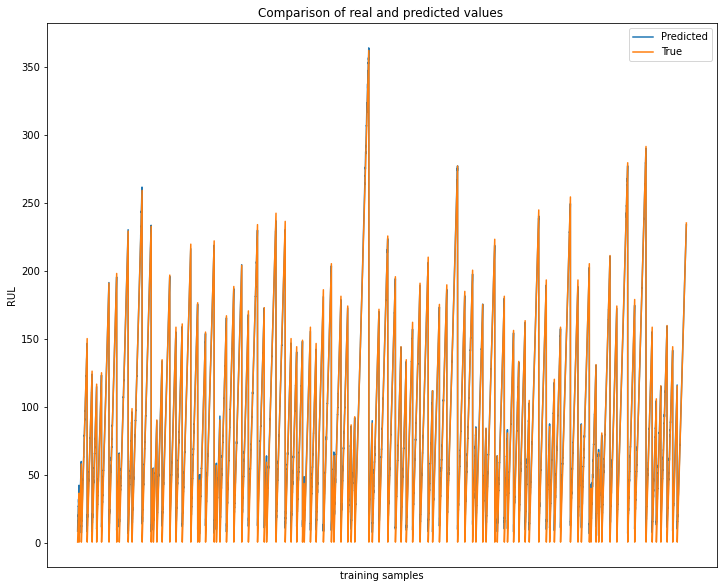

In [ ]:
score_func(inv_y, inv_yhat)
plot_result(inv_y, inv_yhat)

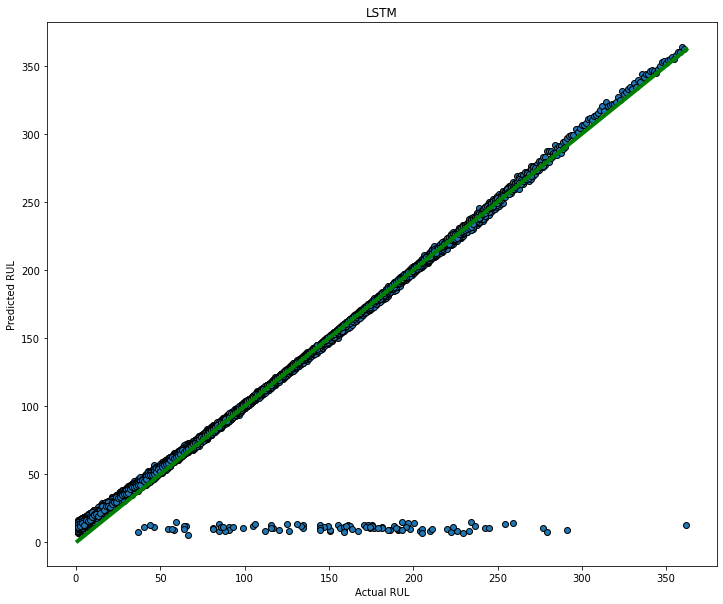

In [ ]:
plot_pred(inv_y, inv_yhat, 'LSTM')